# Airbnb New User Bookings - ML

- My project is to predict where a new Airbnb user will book his/her first travel destination. 

- In this project, I am given a list of users along with their demographics, web session records, and some summary statistics. The goal is to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

- There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.

- The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014.

- In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

In [4]:
import os
import sys
import re
import warnings
warnings.filterwarnings("ignore")

import glob

import random
import time
import math
import missingno as msno
import numpy as np
np.random.seed(42)
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)
plt.rc('xtick', labelsize = 20) 
plt.rc('ytick', labelsize = 20)
plt.rc('text', usetex = True)
import seaborn as sns
sns.set(font_scale = 1.5)
# allow plots to appear directly in the notebook
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from scipy import stats
import scipy.stats as scs


Bad key "text.kerning_factor" on line 4 in
/Users/Helnaz/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [5]:
start = time.time()

# Question 1: Does a new airbnb user book his/her first reservation?

In [6]:
df = pd.read_csv('../data/cleaned_airbnb_sessions.csv', index_col = 0)

In [7]:
df.shape

(72761, 21)

In [8]:
df['country_destination'].value_counts()

ndf      44402
us       19823
other     3591
fr        1416
it         962
gb         715
es         695
ca         434
de         247
nl         244
au         150
pt          82
Name: country_destination, dtype: int64

In [9]:
df.columns

Index(['id', 'date_account_created', 'timestamp_first_active', 'gender', 'age',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'country_destination',
       'unique_action', 'unique_action_type', 'unique_action_detail',
       'device_type', 'secs_elapsed', 'secs_elapsed_mean'],
      dtype='object')

In [10]:
df.describe()

,timestamp_first_active,age,signup_flow,unique_action,unique_action_type,unique_action_detail,device_type,secs_elapsed,secs_elapsed_mean
count,7.276100e+04,72761.000000,72761.000000,72761.000000,72761.000000,72761.000000,72761.000000,7.276100e+04,7.276100e+04
mean,2.014040e+13,35.845003,4.818323,12.574346,4.903726,10.875854,1.314647,7.421730e-18,-2.031210e-17
std,1.710547e+08,8.748636,9.319451,7.985971,1.462161,5.952328,0.558783,1.000007e+00,1.000007e+00
min,2.014010e+13,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-7.929979e-01,-6.653611e-01
25%,2.014023e+13,31.000000,0.000000,7.000000,4.000000,7.000000,1.000000,-6.574620e-01,-4.641441e-01
50%,2.014042e+13,36.585249,0.000000,11.000000,5.000000,10.000000,1.000000,-3.349005e-01,-2.685407e-01
75%,2.014053e+13,36.585249,0.000000,16.000000,6.000000,14.000000,2.000000,2.776838e-01,9.372061e-02
max,2.014063e+13,100.000000,25.000000,71.000000,8.000000,46.000000,6.000000,1.911377e+01,2.084931e+01


In [11]:
# one-hot encoding categorical features
cols = ['gender', 'signup_flow', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider',
        'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
df = pd.get_dummies(df, columns = cols)
df.set_index('id', inplace = True)

In [12]:
df.shape

(72761, 75)

In [13]:
# converting date_account_created to day, month and year

date_created = np.vstack(df.date_account_created.astype(str).apply(lambda x: list(map(int, x.split('-')))).values)
df['dac_year'] = date_created[:, 0]
df['dac_month'] = date_created[:, 1]
df['dac_day'] = date_created[:, 2]
df = df.drop(['date_account_created'], axis = 1)

In [14]:
# timestamp_first_active

first_active = np.vstack(df.timestamp_first_active.astype(str).apply(lambda x: list(map(int, [x[:4],x[4:6],x[6:8],x[8:10],x[10:12],x[12:14]]))).values)
df['tfa_year'] = first_active[:, 0]
df['tfa_month'] = first_active[:, 1]
df['tfa_day'] = first_active[:, 2]
df = df.drop(['timestamp_first_active'], axis = 1)

In [15]:
# retrieving train and test dataset; this step should be done after the data cleaning is finalized:
test_unseen = df[df['country_destination'] == 'tbd']
test_unseen = test_unseen.drop('country_destination', axis = 1).reset_index()

df_final1 = df[df['country_destination'] != 'tbd'].reset_index()
df_final1['country_destination'] = df_final1['country_destination'].apply(lambda x: 1 if x == 'ndf' else 0)

y1 = df_final1['country_destination']
X1 = df_final1.drop(['country_destination', 'id'], axis = 1)

In [16]:
X1.shape

(72761, 78)

In [17]:
round(df_final1.country_destination.mean(), 3)

0.61

### Predictive Modeling

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree, ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, auc, classification_report, log_loss
import xgboost
from xgboost.sklearn import XGBClassifier

### Splitting the dataset into the Training set and Test set

In [16]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.25, random_state = 42, stratify = y1)
# sc = StandardScaler()  
# X_train = sc.fit_transform(X_train1)  
# X_test = sc.transform(X_test1)

In [17]:
y1.mean()

0.6102444991135361

In [18]:
# storing the baseline accuracy score in a dictionary:
accuracy_baseline = {}

In [19]:
evaluation = pd.DataFrame(index = ['logistic regression', 'decision tree', 'random forest', 'gradient boosting', 
                                   'ada boosting', 'xgboosting', 'neural networks', 'multi-layer perceptron'],
                         columns = ['accuracy', 'precision', 'recall', 'log loss', 'auc'])

### Logistic Regression

In [20]:
lrc = LogisticRegression()
lrc.fit(X_train1, y_train1)
y_pred_lrc = lrc.predict(X_test1)
y_prob_lrc = lrc.predict_proba(X_test1)

In [21]:
evaluation.iloc[0,0] = round(accuracy_score(y_test1, y_pred_lrc), 3)
evaluation.iloc[0,1] = round(precision_score(y_test1, y_pred_lrc), 3)
evaluation.iloc[0,2] = round(recall_score(y_test1, y_pred_lrc), 3)
evaluation.iloc[0,3] = round(log_loss(y_test1, y_pred_lrc), 3)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_lrc[:,1])
evaluation.iloc[0,4] = round(auc(fpr, tpr), 3)

In [22]:
lrc_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_lrc),
                      index = ['predicted non_ndf', 'predicted ndf'], 
                      columns = ['actual non_ndf', 'actual ndf'])
lrc_cm

,actual non_ndf,actual ndf
predicted non_ndf,3561,3529
predicted ndf,1863,9238


### Linear SVM

In [23]:
# svmc = svm.SVC()
# svmc.fit(X_train, y_train)
# y_pred_svmc = svmc.predict(X_test)
# (y_pred_svmc == y_test).mean()

### Decision Tree

In [24]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train1, y_train1)
y_pred_dtc = dtc.predict(X_test1)
y_prob_dtc = dtc.predict_proba(X_test1)

In [25]:
evaluation.iloc[1,0] = round(accuracy_score(y_test1, y_pred_dtc), 3)
evaluation.iloc[1,1] = round(precision_score(y_test1, y_pred_dtc), 3)
evaluation.iloc[1,2] = round(recall_score(y_test1, y_pred_dtc), 3)
evaluation.iloc[1,3] = round(log_loss(y_test1, y_pred_dtc), 3)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_dtc[:,1])
evaluation.iloc[1,4] = round(auc(fpr, tpr), 3)

In [26]:
dtc_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_dtc),
                      index = ['predicted non_ndf', 'predicted ndf'], 
                      columns = ['actual non_ndf', 'actual ndf'])
dtc_cm

,actual non_ndf,actual ndf
predicted non_ndf,3971,3119
predicted ndf,3112,7989


### Random Forest

In [27]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(X_train1, y_train1)
y_pred_rfc = rfc.predict(X_test1)
y_prob_rfc = rfc.predict_proba(X_test1)

In [28]:
evaluation.iloc[2,0] = round(accuracy_score(y_test1, y_pred_rfc), 3)
evaluation.iloc[2,1] = round(precision_score(y_test1, y_pred_rfc), 3)
evaluation.iloc[2,2] = round(recall_score(y_test1, y_pred_rfc), 3)
evaluation.iloc[2,3] = round(log_loss(y_test1, y_pred_rfc), 3)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_rfc[:,1])
evaluation.iloc[2,4] = round(auc(fpr, tpr), 3)

In [29]:
rfc_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_rfc),
                      index = ['predicted non_ndf', 'predicted ndf'], 
                      columns = ['actual non_ndf', 'actual ndf'])
rfc_cm

,actual non_ndf,actual ndf
predicted non_ndf,4548,2542
predicted ndf,2138,8963


### Gradient Boosting

In [30]:
gbc = ensemble.GradientBoostingClassifier()
gbc.fit(X_train1, y_train1)
y_pred_gbc = gbc.predict(X_test1)
y_prob_gbc = gbc.predict_proba(X_test1)

In [31]:
evaluation.iloc[3,0] = round(accuracy_score(y_test1, y_pred_gbc), 3)
evaluation.iloc[3,1] = round(precision_score(y_test1, y_pred_gbc), 3)
evaluation.iloc[3,2] = round(recall_score(y_test1, y_pred_gbc), 3)
evaluation.iloc[3,3] = round(log_loss(y_test1, y_pred_gbc), 3)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_gbc[:,1])
evaluation.iloc[3,4] = round(auc(fpr, tpr), 3)

In [32]:
gbc_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_gbc),
                      index = ['predicted non_ndf', 'predicted ndf'], 
                      columns = ['actual non_ndf', 'actual ndf'])
gbc_cm

,actual non_ndf,actual ndf
predicted non_ndf,4691,2399
predicted ndf,2063,9038


In [33]:
temp = []
for col in X_train1.columns:
    col = col.replace('_', ' ')
    temp.append(col)
temp_columns = temp

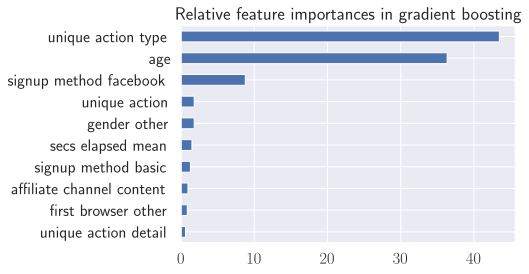

In [34]:
# feature importance
feature_importances = 100*gbc.feature_importances_ / np.sum(gbc.feature_importances_)
feat_importances = pd.Series(feature_importances, index=temp_columns)
feat_importances.nlargest(10, keep='first')[::-1].plot(kind='barh')
plt.xlabel('')
plt.ylabel('')
plt.title('Relative feature importances in gradient boosting')
plt.savefig('../figure/feature_importances_gbc1.png', bbox_inches='tight')

In [35]:
# X_trainfi = X_train1.iloc[:,list(np.argsort(fi_relative))[::-1][:20]]
# X_testfi = X_test1.iloc[:,list(np.argsort(fi_relative))[::-1][:20]]
# gbc.fit(X_trainfi, y_train1)
# y_pred_gbcfi = gbc.predict(X_testfi)
# y_prob_gbcfi = gbc.predict_proba(X_test1)

In [36]:
# print('accuracy score is: ', round(accuracy_score(y_test1, y_pred_gbcfi), 3))
# print('precision score is: ', round(precision_score(y_test1, y_pred_gbcfi), 3))
# print('recall score is: ', round(recall_score(y_test1, y_pred_gbcfi), 3))

In [37]:
# gbcfi_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_gbcfi),
#                       index = ['predicted non_ndf', 'predicted ndf'], 
#                       columns = ['actual non_ndf', 'actual ndf'])
# gbcfi_cm

### Ada Boosting

In [38]:
abc = ensemble.AdaBoostClassifier()
abc.fit(X_train1, y_train1)
y_pred_abc = abc.predict(X_test1)
y_prob_abc = abc.predict_proba(X_test1)

In [39]:
evaluation.iloc[4,0] = round(accuracy_score(y_test1, y_pred_abc), 3)
evaluation.iloc[4,1] = round(precision_score(y_test1, y_pred_abc), 3)
evaluation.iloc[4,2] = round(recall_score(y_test1, y_pred_abc), 3)
evaluation.iloc[4,3] = round(log_loss(y_test1, y_pred_abc), 3)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_abc[:,1])
evaluation.iloc[4,4] = round(auc(fpr, tpr), 3)

In [40]:
abc_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_abc),
                      index = ['predicted non_ndf', 'predicted ndf'], 
                      columns = ['actual non_ndf', 'actual ndf'])
abc_cm

,actual non_ndf,actual ndf
predicted non_ndf,4201,2889
predicted ndf,1794,9307


### XGBoosting

In [41]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()                  
xgb.fit(X_train1, y_train1)
y_pred_xgb = xgb.predict(X_test1)
y_prob_xgb = xgb.predict_proba(X_test1)

In [42]:
evaluation.iloc[5,0] = round(accuracy_score(y_test1, y_pred_xgb), 3)
evaluation.iloc[5,1] = round(precision_score(y_test1, y_pred_xgb), 3)
evaluation.iloc[5,2] = round(recall_score(y_test1, y_pred_xgb), 3)
evaluation.iloc[5,3] = round(log_loss(y_test1, y_pred_xgb), 3)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_xgb[:,1])
evaluation.iloc[5,4] = round(auc(fpr, tpr), 3)

In [43]:
xgb_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_xgb),
                      index = ['predicted non_ndf', 'predicted ndf'], 
                      columns = ['actual non_ndf', 'actual ndf'])
xgb_cm

,actual non_ndf,actual ndf
predicted non_ndf,4636,2454
predicted ndf,2027,9074


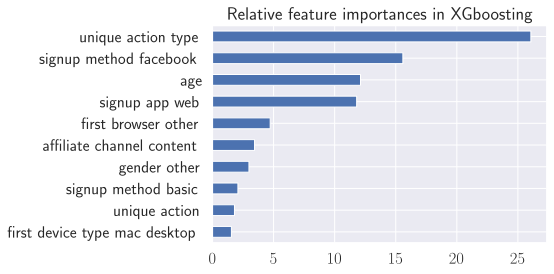

In [44]:
# feature importance
feature_importances = 100*xgb.feature_importances_ / np.sum(xgb.feature_importances_)
feat_importances = pd.Series(feature_importances, index=temp_columns)
feat_importances.nlargest(10, keep='first')[::-1].plot(kind='barh')
plt.xlabel('')
plt.ylabel('')
plt.title('Relative feature importances in XGboosting')
plt.savefig('../figure/feature_importances_xgb1.png', bbox_inches='tight')

In [45]:
# X_trainfi = X_train1.iloc[:,list(np.argsort(fi_relative))[::-1][:20]]
# X_testfi = X_test1.iloc[:,list(np.argsort(fi_relative))[::-1][:20]]
# gbc.fit(X_trainfi, y_train1)
# y_pred_xgbfi = xgb.predict(X_testfi)
# y_prob_xgbfi = xgb.predict_proba(X_test1)

In [46]:
# print('accuracy score is: ', round(accuracy_score(y_test1, y_pred_xgbfi), 3))
# print('precision score is: ', round(precision_score(y_test1, y_pred_xgbfi), 3))
# print('recall score is: ', round(recall_score(y_test1, y_pred_xgbfi), 3))

In [47]:
# xgbfi_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_xgbfi),
#                       index = ['predicted non_ndf', 'predicted ndf'], 
#                       columns = ['actual non_ndf', 'actual ndf'])
# xgbfi_cm

### Neural Netwroks

In [48]:
nnc = Perceptron(tol=1e-3, random_state=42)
nnc.fit(X_train1, y_train1)
y_pred_nnc = nnc.predict(X_test1)

In [49]:
evaluation.iloc[6,0] = round(accuracy_score(y_test1, y_pred_nnc), 3)
evaluation.iloc[6,1] = round(precision_score(y_test1, y_pred_nnc), 3)
evaluation.iloc[6,2] = round(recall_score(y_test1, y_pred_nnc), 3)
evaluation.iloc[6,3] = round(log_loss(y_test1, y_pred_nnc), 3)

evaluation.iloc[6,4] = 'NA'

In [50]:
nnc_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_nnc),
                      index = ['predicted non_ndf', 'predicted ndf'], 
                      columns = ['actual non_ndf', 'actual ndf'])
nnc_cm

,actual non_ndf,actual ndf
predicted non_ndf,6513,577
predicted ndf,9634,1467


### MLP Classifier

In [51]:
mlp = MLPClassifier(tol=1e-3, random_state=42)
mlp.fit(X_train1, y_train1)
y_pred_mlp = mlp.predict(X_test1)
y_prob_mlp = mlp.predict_proba(X_test1)

In [52]:
evaluation.iloc[7,0] = round(accuracy_score(y_test1, y_pred_mlp), 3)
evaluation.iloc[7,1] = round(precision_score(y_test1, y_pred_mlp), 3)
evaluation.iloc[7,2] = round(recall_score(y_test1, y_pred_mlp), 3)
evaluation.iloc[7,3] = round(log_loss(y_test1, y_pred_mlp), 3)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_mlp[:,1])
evaluation.iloc[7,4] = round(auc(fpr, tpr), 3)

In [53]:
mlp_cm = pd.DataFrame(confusion_matrix(y_test1, y_pred_mlp),
                      index = ['predicted non_ndf', 'predicted ndf'], 
                      columns = ['actual non_ndf', 'actual ndf'])
mlp_cm

,actual non_ndf,actual ndf
predicted non_ndf,5033,2057
predicted ndf,3563,7538


In [54]:
evaluation.drop('neural networks', inplace=True)
evaluation

,accuracy,precision,recall,log loss,auc
logistic regression,0.704,0.724,0.832,10.238,0.736
decision tree,0.657,0.719,0.72,11.831,0.64
random forest,0.743,0.779,0.807,8.886,0.803
gradient boosting,0.755,0.79,0.814,8.472,0.813
ada boosting,0.743,0.763,0.838,8.892,0.805
xgboosting,0.754,0.787,0.817,8.508,0.813
multi-layer perceptron,0.691,0.786,0.679,10.671,0.752


### ROC Curve

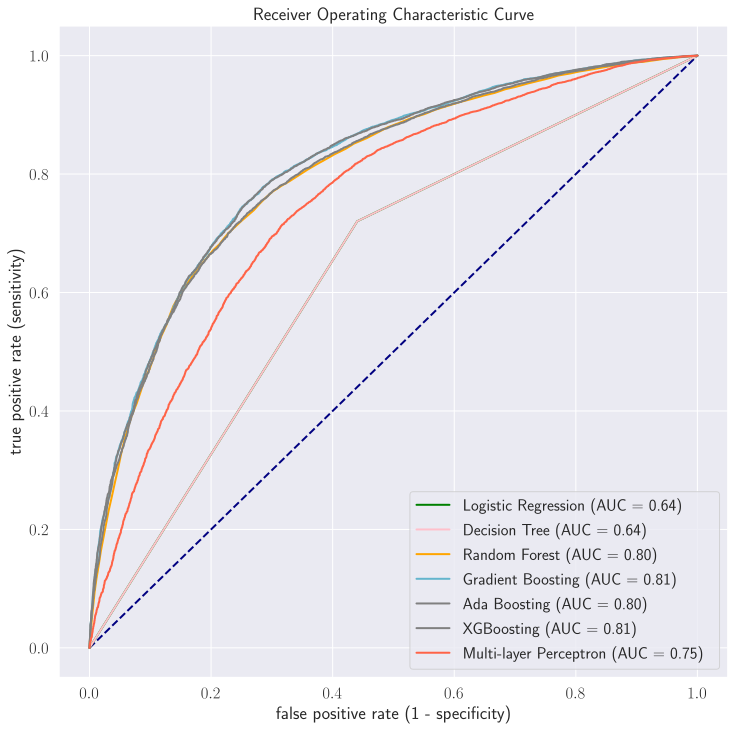

In [61]:
plt.figure(figsize=(12,12))
lw = 2
plt.plot([0, 1], [0, 1],lw=lw, color='navy', linestyle='--')

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_dtc[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc)

# fpr, tpr, thresholds = roc_curve(y_test, y_prob_svmc[:, 1])
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, color='deeppink',lw=lw, label='Support Vector (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_dtc[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='pink',lw=lw, label='Decision Tree (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_rfc[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange',lw=lw, label='Random Forest (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_gbc[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='c',lw=lw, label='Gradient Boosting (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_abc[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='gray',lw=lw, label='Ada Boosting (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_xgb[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='gray',lw=lw, label='XGBoosting (AUC = %0.2f)' % roc_auc)

# no pred_prob for nnc

fpr, tpr, thresholds = roc_curve(y_test1, y_prob_mlp[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='tomato',lw=lw, label='Multi-layer Perceptron (AUC = %0.2f)' % roc_auc)

plt.xlabel('false positive rate (1 - specificity)')
plt.ylabel('true positive rate (sensitivity)')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc = "best")
plt.grid(True)
plt.savefig('../figure/final_auc_all_proba.png', dpi=300, bbox_inches='tight')

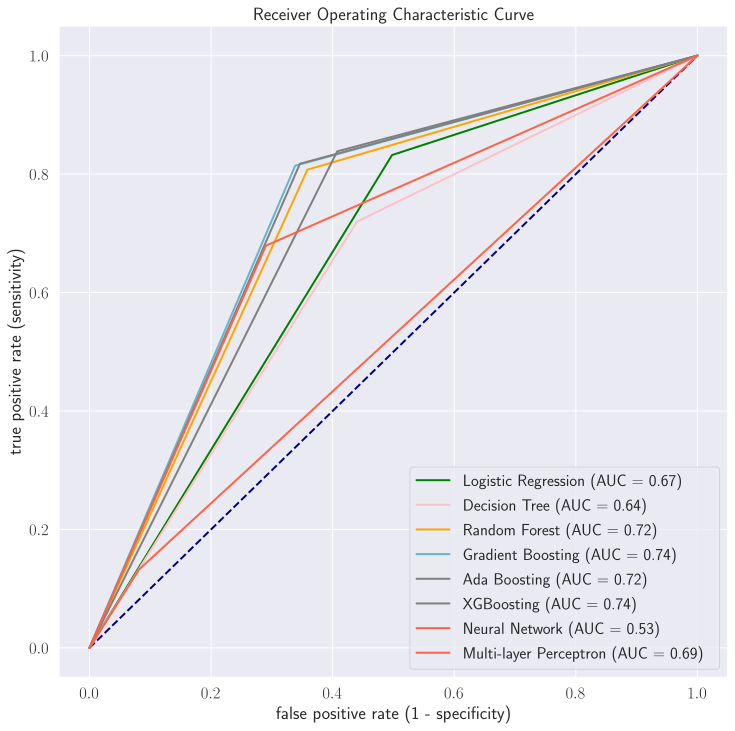

In [60]:
plt.figure(figsize=(12,12))
lw = 2
plt.plot([0, 1], [0, 1],lw=lw, color='navy', linestyle='--', label='Logistic Regression (AUC = %0.2f)')

fpr, tpr, thresholds = roc_curve(y_test1, y_pred_lrc)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='green',lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc)

# fpr, tpr, thresholds = roc_curve(y_test, y_pred_svmc)
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, color='deeppink',lw=lw, label='Support Vector (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_pred_dtc)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='pink',lw=lw, label='Decision Tree (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_pred_rfc)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='orange',lw=lw, label='Random Forest (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_pred_gbc)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='c',lw=lw, label='Gradient Boosting (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_pred_abc)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='gray',lw=lw, label='Ada Boosting (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_pred_xgb)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='gray',lw=lw, label='XGBoosting (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_pred_nnc)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='tomato',lw=lw, label='Neural Network (AUC = %0.2f)' % roc_auc)

fpr, tpr, thresholds = roc_curve(y_test1, y_pred_mlp)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='tomato',lw=lw, label='Multi-layer Perceptron (AUC = %0.2f)' % roc_auc)

plt.xlabel('false positive rate (1 - specificity)')
plt.ylabel('true positive rate (sensitivity)')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc = "best")
plt.grid(True)
plt.savefig('../figure/final_auc_all.png', dpi=300, bbox_inches='tight')

# Question 2: Where does a new airbnb user book his/her first reservation?

In [19]:
from sklearn.preprocessing import LabelEncoder
# Encode target labels with value between 0 and n_classes-1.

In [20]:
test_unseen = df[df['country_destination'] == 'TBD']
test_unseen = test_unseen.drop('country_destination', axis = 1).reset_index()

df_final2 = df[(df['country_destination'] != 'ndf') & (df['country_destination'] != 'tbd')].reset_index()
# df_final2[(df_final2['country_destination'] == 'OTHER')] = 'OTH'
y2 = df_final2['country_destination']
X2 = df_final2.drop(['country_destination', 'id'], axis = 1)
label_encoder = LabelEncoder()
y2 = label_encoder.fit_transform(y2) # labeling the target variables

In [21]:
percentage = df_final2['country_destination'].value_counts() / df_final2.shape[0] * 100
sns.countplot(data = df_final2, x = 'country_destination', order = percentage.index, color = 'b')
plt.xlabel('')
plt.ylabel('counts')
plt.ylim(0, 25000)
plt.xticks(size = 12)
plt.title('country destination distribution');
plt.grid(False)
for i in range(percentage.shape[0]):
    strt = '{:0.1f}%'.format(percentage[i])
    plt.text(i, df_final2['country_destination'].value_counts()[i] + 1000, strt, ha = 'center', size = 16)
    
plt.savefig('../figure/country_destination_distribution_q2', dpi = 300, bbox_inches = 'tight');

In [22]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = 0.25, random_state = 42, stratify = y2)
# sc = StandardScaler()  
# X_train = sc.fit_transform(X_train)  
# X_test = sc.transform(X_test)

In [23]:
X_train2.columns

Index(['age', 'unique_action', 'unique_action_type', 'unique_action_detail',
       'device_type', 'secs_elapsed', 'secs_elapsed_mean', 'gender_female',
       'gender_male', 'gender_other', 'signup_flow_0.0', 'signup_flow_8.0',
       'signup_flow_12.0', 'signup_flow_21.0', 'signup_flow_23.0',
       'signup_flow_24.0', 'signup_flow_25.0', 'signup_method_basic',
       'signup_method_facebook', 'signup_method_google', 'language_en',
       'language_other', 'affiliate_channel_api', 'affiliate_channel_content',
       'affiliate_channel_direct', 'affiliate_channel_other',
       'affiliate_channel_remarketing', 'affiliate_channel_sem-brand',
       'affiliate_channel_sem-non-brand', 'affiliate_channel_seo',
       'affiliate_provider_baidu', 'affiliate_provider_bing',
       'affiliate_provider_craigslist', 'affiliate_provider_daum',
       'affiliate_provider_direct', 'affiliate_provider_email-marketing',
       'affiliate_provider_facebook', 'affiliate_provider_facebook-open-graph',


### Undersampling
- For the data with country = 'US'

In [24]:
# from imblearn.under_sampling import NearMiss

# X_train2_arr = np.array(X_train2)
# nm = NearMiss()
# X_res, y_res = nm.fit_sample(X_train2_arr, y_train2)

# from collections import Counter
# print('Original dataset shape {}'.format(Counter(y_train2)))
# print('Resampled dataset shape {}'.format(Counter(y_res)))

In [132]:
# from imblearn.under_sampling import RandomUnderSampler

# X_train2_arr = np.array(X_train2)
# os =  RandomUnderSampler(sampling_strategy={10: 10000}, random_state=42)
# X_res, y_res = os.fit_sample(X_train2_arr, y_train2)
# X_res.shape, y_res.shape

In [133]:
# from collections import Counter
# print('Original dataset shape {}'.format(Counter(y_train2)))
# print('Resampled dataset shape {}'.format(Counter(y_res)))

In [280]:
# X_train2 = X_res
# y_train2 = y_res

### Oversampling
- For the rest of countries

In [281]:
# from imblearn.over_sampling import SMOTE

# X_train2_arr = np.array(X_train2)
# os_smote = SMOTE(sampling_strategy='not majority')
# X_res, y_res = os_smote.fit_sample(X_train2_arr, y_train2)
# X_res.shape, y_res.shape

In [282]:
# from collections import Counter
# print('Original dataset shape {}'.format(Counter(y_train2)))
# print('Resampled dataset shape {}'.format(Counter(y_res)))

In [283]:
# from imblearn.over_sampling import RandomOverSampler

# X_train2_arr = np.array(X_train2)
# os =  RandomOverSampler(random_state=42)
# X_res, y_res = os.fit_sample(X_train2_arr, y_train2)
# X_res.shape, y_res.shape

In [284]:
# from collections import Counter
# print('Original dataset shape {}'.format(Counter(y_train2)))
# print('Resampled dataset shape {}'.format(Counter(y_res)))

In [285]:
# X_train2 = pd.DataFrame(X_res, columns = X_test2.columns)
# y_train2 = y_res

- The predictive model would be biased towards Class1 in the case of imbalance.

In [326]:
unique, counts = np.unique(y_test2, return_counts=True)

In [327]:
unique, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 array([  37,  108,   62,  174,  354,  179,  241,   61,  898,   20, 4956]))

In [25]:
def scorer(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)
    cts = []  #list of countries
    for i in range(len(y_test)):
        cts.append(np.argsort(y_pred[i])[::-1][:5].tolist())
    cts = pd.DataFrame(cts)
    y_val = pd.Series(y_test)
    return score_predictions(cts, y_test)

In [26]:
def dcg_at_k(r, k=5, method=2):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(2**r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(r, k=5, method=2):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

def score_predictions(preds, truth, n_modes=5):
    """
    preds: pd.DataFrame
      one row for each observation, one column for each prediction.
      Columns are sorted from left to right descending in order of likelihood.
    truth: pd.Series
      one row for each obeservation.
    """
    assert(len(preds)==len(truth))
    r = pd.DataFrame(0, index=preds.index, columns=preds.columns, dtype=np.float64)
    for col in preds.columns:
        r[col] = (preds[col] == truth) * 1.0

    score = pd.Series(r.apply(ndcg_at_k, axis=1), name='score')
    return score

In [169]:
# # with undersampling + oversampling
# from xgboost.sklearn import XGBClassifier
# xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
#                     objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0) 
# my_score = scorer(xgb, X_train2, y_train2, X_test2, y_test2)
# my_score.mean()

In [137]:
# # if we select 5 random numbers for each target variable
# rand_country = []
# for i in range(y_test2.shape[0]):
#     rand_country.append(np.random.randint(1,11,5))
# random_score = score_predictions(pd.DataFrame(rand_country), y_test2, n_modes=5)
# random_score.mean()

In [138]:
# # if we choose all the target variable to be US
# rand_country = np.ones((y_test2.shape[0], 1)) * 10
# random_score = score_predictions(pd.DataFrame(rand_country), y_test2, n_modes=5)
# random_score.mean()

In [139]:
# (y_test2 == 10).mean()

In [27]:
lrc = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
abc = AdaBoostClassifier()
xgb = XGBClassifier()                  
mlp = MLPClassifier(tol=1e-3, random_state=0)

In [28]:
models = [lrc, dtc, rfc, gbc, abc, xgb, mlp]
names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 
         'Ada Boosting', 'XGBoosting', 'MLP Classifier']

for model, name in zip(models, names):
    my_score = scorer(model, X_train2, y_train2, X_test2, y_test2)
    print('The score for', name, 'is :', round(my_score.mean(), 3))

In [189]:
# evaluation_2 = pd.DataFrame(index = ['logistic regression', 'decision tree', 'random forest', 'gradient boosting', 
#                                    'ada boosting', 'xgboosting', 'multi-layer perceptron'],
#                          columns = ['k = 3', 'k = 4', 'k = 5'])

In [199]:
evaluation_2['k = 3'] = [0.804, 0.684, 0.792, 0.796, 0.801, 0.802, 0.779]
evaluation_2['k = 4'] = [0.819, 0.7, 0.809, 0.811, 0.815, 0.819, 0.794]
evaluation_2['k = 5'] = [0.829, 0.71, 0.82, 0.822, 0.827, 0.828, 0.803]
evaluation_2

,k = 3,k = 4,k = 5
logistic regression,0.804,0.819,0.829
decision tree,0.684,0.700,0.710
random forest,0.792,0.809,0.820
gradient boosting,0.796,0.811,0.822
ada boosting,0.801,0.815,0.827
xgboosting,0.802,0.819,0.828
multi-layer perceptron,0.779,0.794,0.803


In [188]:
evaluation_3 = pd.DataFrame(index = ['logistic regression', 'decision tree', 'random forest', 'gradient boosting', 
                                   'ada boosting', 'xgboosting', 'multi-layer perceptron'],
                         columns = ['k = 3', 'k = 4', 'k = 5'])

In [198]:
evaluation_3['k = 3'] = [0.857, 0.782, 0.843, 0.852, 0.856, 0.855, 0.81]
evaluation_3['k = 4'] = [0.874, 0.797, 0.859, 0.87, 0.871, 0.874, 0.828]
evaluation_3['k = 5'] = [0.886, 0.81, 0.871, 0.883, 0.885, 0.885, 0.837]
evaluation_3

,k = 3,k = 4,k = 5
logistic regression,0.857,0.874,0.886
decision tree,0.782,0.797,0.810
random forest,0.843,0.859,0.871
gradient boosting,0.852,0.870,0.883
ada boosting,0.856,0.871,0.885
xgboosting,0.855,0.874,0.885
multi-layer perceptron,0.810,0.828,0.837


### Gradient Boosting feature importance

In [183]:
gbc2 = ensemble.GradientBoostingClassifier()
gbc2.fit(X_train2, y_train2)
y_pred_gbc2 = gbc2.predict(X_test2)

0.687


In [200]:
temp = []
for col in X_train2.columns:
    col = col.replace('_', ' ')
    temp.append(col)
temp_columns = temp

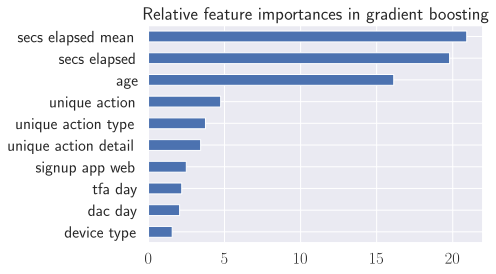

In [147]:
# feature importance
feature_importances = 100*gbc2.feature_importances_ / np.sum(gbc2.feature_importances_)
feat_importances = pd.Series(feature_importances, index=temp_columns)
feat_importances.nlargest(10, keep='first')[::-1].plot(kind='barh')
plt.xlabel('')
plt.ylabel('')
plt.title('Relative feature importances in gradient boosting')
plt.savefig('../figure/feature_importances_gbc2.png', bbox_inches='tight')

### Ada Boosting feature importance

In [201]:
abc2 = ensemble.AdaBoostClassifier()
abc2.fit(X_train2, y_train2)
y_pred_abc2 = abc2.predict(X_test2)
round((y_pred_abc2 == y_test2).mean(), 3)

0.694

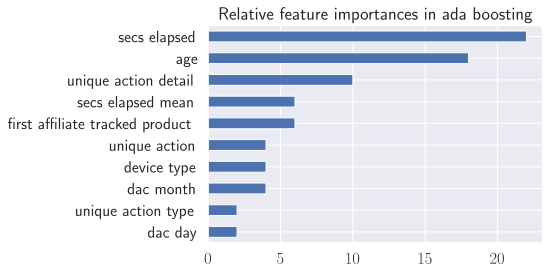

In [235]:
# feature importance
feature_importances = 100*abc2.feature_importances_ / np.sum(abc2.feature_importances_)
feat_importances = pd.Series(feature_importances, index=temp_columns)
feat_importances.nlargest(10, keep='first')[::-1].plot(kind='barh')
plt.xlabel('')
plt.ylabel('')
plt.title('Relative feature importances in ada boosting')
plt.savefig('../figure/feature_importances_ada2.png', bbox_inches='tight')

### XGBoosting feature importance

In [203]:
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()                  
xgb.fit(X_train1, y_train1)
y_pred_xgb = xgb.predict(X_test1)
y_prob_xgb = xgb.predict_proba(X_test1)

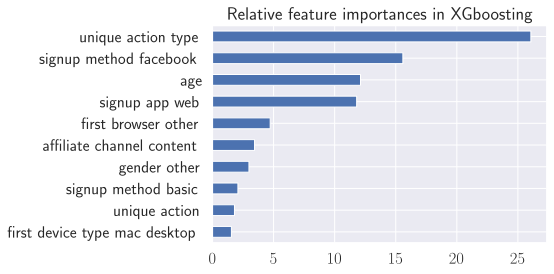

In [204]:
# feature importance
feature_importances = 100*xgb.feature_importances_ / np.sum(xgb.feature_importances_)
feat_importances = pd.Series(feature_importances, index=temp_columns)
feat_importances.nlargest(10, keep='first')[::-1].plot(kind='barh')
plt.xlabel('')
plt.ylabel('')
plt.title('Relative feature importances in XGboosting')
plt.savefig('../figure/feature_importances_xgb2.png', bbox_inches='tight')

### Ada Boosting GridsearchCV

In [95]:
# verbose = 1 in GridSearchCV --> it shows the progress
# the order in param matters for the running time
# param = {'n_estimators': [50, 100, 200, 500, 1000],
#          'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
#          'algorithm': ['SAMME', 'SAMME.R']}
# scorings = ['accuracy', 'precision', 'recall']
# GCV = GridSearchCV(abc, param_grid = param, scoring = scorings, verbose = 1, refit = 'accuracy')
# GCV.fit(X_train2, y_train2)
# GCV.cv_results_